<div style="text-align: center;">
    <a href="https://www.ip-paris.fr/">
        <img border="0" src="img/IPP.png" width="90%"></a>
</div>

# Prediction of operational demand for SDIS 91 firefighters

<b> Institut Polytechnique de Paris - M2 Data Sciences

DataCamp 2024 </b>

<i> Tristan Waddington, Dimitri Iratchet et Fabien Lagnieu
(IPP / CEMS-T)</i>


<div style="text-align: center;">
<img src="img/pompier.png" width=600px alt="Firefighter"></img>
</div>

---

## Introduction


This challenge aims to predict the number of weekly interventions by type of operation and by municipality for the year 2018 in the Essonne department (91), using historical weekly data. This analysis is crucial for developing the [Departmental Risk Analysis and Coverage Scheme (SDACR)](extra_folders/SDACR%202023-2028.webarchive), a strategic plan used in each department in France to organize and manage emergency services.

<div style="text-align: center;">
<img src="img/SDACR.jpg" width=250px alt="Couverture du SDACR du SDIS 91"></img>
</div>

The SDACR is a fundamental tool for risk management at the departmental level. It is a strategic document that helps forecast, organize, and coordinate the human and material resources needed to respond to major risks that may occur in a department, such as fires, road accidents, natural disasters, and more. The goal is to ensure that emergency resources are adapted to the specific needs of each municipality and are deployed efficiently.

One key to successful planning is anticipation. By predicting the number of interventions by type and by municipality, it is possible to better organize the available resources.

<div class="alert alert-block alert-success">
<u>Here is what this analysis allows us to do concretely</u>:<br>
- <b>Optimize the deployment of emergency resources</b>: By identifying at-risk areas and the most frequent types of interventions in advance, emergency services can better position their teams and equipment. This helps save time and respond more quickly.<br>
- <b>Plan specific interventions</b>: For example, specialized equipment may be needed for road accidents. Accurate forecasting helps determine where and when these resources should be mobilized, ensuring their availability.<br>
- <b>Enhance team responsiveness</b>: By anticipating needs, it becomes possible to better train and prepare teams, as well as organize the setup of emergency posts with the right personnel, based on the predicted interventions.<br>

<b>In summary, accurate and reliable analysis of historical data not only allows for better action planning but also ensures more responsive and efficient management of emergency resources, while improving public safety on a daily basis.</b>
</div>




<div style="text-align: center;">
<img src="img/Carte_sdis91.png" width=250px alt="Carte de déploiement SDIS91"></img> <img ></img> <img ></img>  <img ></img>      
<img src="img/sdis91.png.jpg" width=350px alt="Engin SDIS 91"></img>
</div>

<div class="alert alert-block alert-success">
<b>The objective of this challenge is to predict the number of weekly interventions by type of operation and by municipality for the year 2018 in the Essonne department (91)</b>, using historical weekly data. This challenge aims to anticipate emergency intervention needs to better manage resources and the allocation of rescue teams.
</div>

The data used for this challenge comes from three main datasets:

1.	**Weekly Interventions:** This file contains the actual interventions carried out each week, detailed by type of operation and municipality, over the period from 2010 to 2017. It provides a detailed overview of the operations carried out by rescue teams on a weekly basis, offering a clear view of team demands over time.  **This will be the target to predict for 2018**.

2.	**Municipality Characteristics:** This dataset provides socio-demographic and structural information about some municipalities in Essonne, such as age distribution, education level, and indicators on families and households. These characteristics can influence the frequency of interventions depending on the population and local dynamics.  

3.	**Variability Characteristics:** This file contains a set of factors that vary weekly, such as weather conditions, pollution, pollen levels, flu and diarrhea cases, and other elements impacting intervention demand. These data span the period from 2014 to 2018 and allow capturing the weekly dynamics of environmental and health factors influencing the demand for rescue services.  

The two last datasets will be merged during the processing of the .csv files to form the X file.
The main objective of this challenge is to predict, based on these weekly data, the number of interventions for each municipality and each type of operation for the following year. 
<div class="alert alert-block alert-warning">
This challenge involves a <b>multi-label prediction</b> approach, where each type of operation (SUAP, INCN, INCU, ACCI, AUTR) can be treated independently, but all predictions must coexist within the same model. In other words, the model must be able to predict multiple outcomes simultaneously for each week and each municipality. <code>y.shape = (, 5)</code>
</div>

#### Extra resources

For this challenge, you can take a look at the following resources:

- [`Imbalanced-learn`](https://imbalanced-learn.org/stable/index.html#): a library for handling imbalanced datasets with a focus on resampling techniques. Imbalanced-learn provides powerful tools like SMOTE (Synthetic Minority Over-sampling Technique) and RandomUnderSampler, which can help you address the problem of rare classes in your multi-label prediction task. These techniques are compatible with scikit-learn and can be easily integrated into your model pipeline to improve predictions for categories with few interventions, such as INCN (natural fire) or smaller municipalities with limited data.
- [`skada`](https://scikit-adaptation.github.io/): a library for domain adaptation (DA) with a scikit-learn and PyTorch/skorch compatible API. This library implement many existing DA methods and can be used to implement your own methods.


<div style="display: flex; justify-content: center; align-items: center; gap: 50px;">
    <a href="https://imbalanced-learn.org/stable/">
        <img src="img/Imbalanced_learn.png" height=100px alt="Logo Imbalanced Learn">
    </a>
    <a href="https://scikit-adaptation.github.io/index.html">
        <img src="https://scikit-adaptation.github.io/_images/skada_logo_full.svg" height=100px>
    </a>
</div>


---

## 1. Exploratory data analysis

This notebook provides a simple exploratory data analysis of the dataset.

In [11]:
# %matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from pathlib import Path

### 1.1. Load the data

For this challenge, the data consists of three datasets containing information about the weekly interventions of firefighters in the Essonne department, as well as additional features about municipalities and variability factors that may influence the frequency of interventions.

The data comes from two primary sources:
- INSEE: The National Institute of Statistics and Economic Studies (INSEE) provides the municipal features (such as population demographics, etc.) using the official INSEE codes for municipalities in France.
- data.gouv.fr: The data on variability features and weekly interventions comes from open datasets available on the French government’s open data portal (data.gouv.fr), which provides detailed records of fire department interventions and environmental factors.


The first part of the notebook digs into these files independently, and explains the processing that is done during the construction of the X file. We will begin by loading all three datasets (i.e., communes_features, variability_features, and interventions_features) and examine their structure, types, and any missing values. This exploration will help us understand how the data is organized and prepare for the next steps in the analysis and modeling.

---

In [3]:
print("### Checking if data files are present")
data_files = [
    "data/interventions-hebdo-2010-2017.csv",
    "data/91-variability-features.csv",
    "data/91-communes-features.csv",
    "data/interventions-sdis91.csv",
]
if all(os.path.exists(file) for file in data_files):
    print("   Files already exist")
else:
    print("   Files are missing : downloading from web")
    os.system("python3 download_data.py")

### Checking if data files are present
   Files already exist


### 1.2. Exploration of the target `interventions`

This dataset contains **weekly data on firefighter interventions** in the Essonne department. It provides the number of interventions categorized into five types for each municipality, identified by their INSEE codes:

- `SUAP` : Emergency assistance to people  
- `INCN` : Natural fire  
- `INCU` : Urban fire  
- `ACCI` : Road accident  
- `AUTR` : Other  

This dataset covers the historical period from **2010 to 2017**. Your task is to predict this same data for 2018.
<div style="display: flex; justify-content: center; align-items: center; gap: 50px;">
  <img src="img/INC.png.jpeg" width=382px alt="INCN"></img>
  <img src="img/ACCI.jpg" width=450px alt="ACCI"></img>
</div>

*Two interventions: left a natural fire `INCN`, right a road accident `ACCI`.*

**Data Dictionary**

- `ope_code_insee` : INSEE code of the municipality where the interventions occurred  
- `nb_ope` : Number of interventions carried out  
- `ope_annee` : Year of the interventions  
- `ope_semaine` : Week of the interventions (Weeks start on Monday morning and end on Sunday midnight according to ISO 8601)  
- `ope_categorie` : Category of the interventions (as listed above)  
- `ope_code_postal` : Postal code of the municipality where the interventions occurred  
  - *Note: The postal code is informative only as it does not uniquely identify municipalities. A postal code may be shared by multiple municipalities, leading to mapping issues.*  
- `ope_nom_commune` : Name of the municipality where the interventions occurred  
  - *Note: Informative only, as only the INSEE code is authoritative.*  

This dataset is produced by the **Direction du SDIS91**.

In [4]:
interventions_features = pd.read_csv(
    "data/interventions-hebdo-2010-2017.csv", sep=";"
)

print("\n### interventions_features: First 5 Rows")
display(interventions_features.head())

# suppress lines with only NaN values"
interventions_features.dropna(how="all", inplace=True)

print("\n### communes_features: Number of unique municipalities")
print(interventions_features["ope_code_insee"].nunique())

print("\n### interventions_features: Data Types and Basic Statistics")
display(interventions_features.info())
display(interventions_features.describe(include="all"))

# print("\n### interventions_features: statistics for each ope_categorie")
# ope_categories = interventions_features["ope_categorie"].unique()
# for ope_category in ope_categories:
#     print(f"\n### {ope_category}")
#     display(
#         interventions_features[
#             interventions_features["ope_categorie"] == ope_category
#         ].describe(include="all")
#     )



### interventions_features: First 5 Rows


,ope_code_insee,nb_ope,ope_annee,ope_semaine,ope_categorie,ope_code_postal,ope_nom_commune
0,91001.0,0.0,2010.0,1.0,INCN,91150.0,ABBEVILLE LA RIVIERE
1,91016.0,0.0,2010.0,1.0,INCN,91670.0,ANGERVILLE
2,91017.0,0.0,2010.0,1.0,INCN,91470.0,ANGERVILLIERS
3,91021.0,0.0,2010.0,1.0,INCN,91290.0,ARPAJON
4,91022.0,0.0,2010.0,1.0,INCN,91690.0,ARRANCOURT



### communes_features: Number of unique municipalities
196

### interventions_features: Data Types and Basic Statistics
<class 'pandas.core.frame.DataFrame'>
Index: 405041 entries, 0 to 405040
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ope_code_insee   405041 non-null  float64
 1   nb_ope           405041 non-null  float64
 2   ope_annee        405041 non-null  float64
 3   ope_semaine      405041 non-null  float64
 4   ope_categorie    405041 non-null  object 
 5   ope_code_postal  405041 non-null  float64
 6   ope_nom_commune  405041 non-null  object 
dtypes: float64(5), object(2)
memory usage: 24.7+ MB


None

,ope_code_insee,nb_ope,ope_annee,ope_semaine,ope_categorie,ope_code_postal,ope_nom_commune
count,405041.000000,405041.000000,405041.000000,405041.000000,405041,405041.000000,405041
unique,NaN,NaN,NaN,NaN,5,NaN,196
top,NaN,NaN,NaN,NaN,SUAP,NaN,CORBEIL ESSONNES
freq,NaN,NaN,NaN,NaN,81536,NaN,2117
mean,91349.661326,1.753445,2013.499693,26.500569,NaN,91506.394933,NaN
std,205.787870,6.219982,2.291316,15.007117,NaN,311.423973,NaN
min,91001.000000,0.000000,2010.000000,1.000000,NaN,91000.000000,NaN
25%,91161.000000,0.000000,2011.000000,14.000000,NaN,91300.000000,NaN
50%,91340.000000,0.000000,2013.000000,27.000000,NaN,91510.000000,NaN
75%,91540.000000,1.000000,2015.000000,39.000000,NaN,91690.000000,NaN


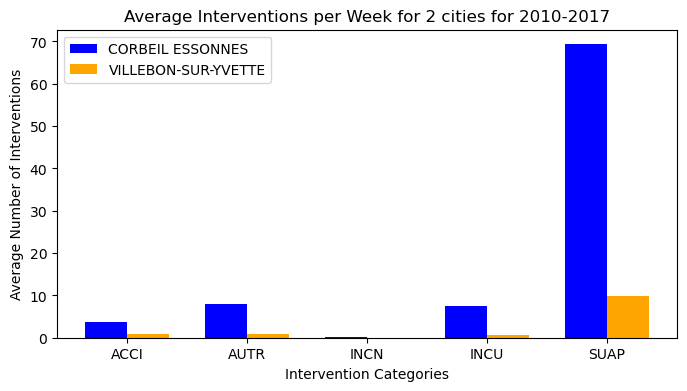

In [7]:
# Display the discprepancy of interventions between communes.
mean_interventions = (
    interventions_features.groupby(["ope_nom_commune", "ope_categorie"])[
        "nb_ope"
    ]
    .mean()
    .unstack()
)
corbeil_values = mean_interventions.loc["CORBEIL ESSONNES"]
villebon_values = mean_interventions.loc["VILLEBON SUR YVETTE"]
categories = mean_interventions.columns

bar_width = 0.35
index = np.arange(len(categories))
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(index, corbeil_values, bar_width, label="CORBEIL ESSONNES", color="blue")
ax.bar(
    index + bar_width,
    villebon_values,
    bar_width,
    label="VILLEBON-SUR-YVETTE",
    color="orange",
)
ax.set_xlabel("Intervention Categories")
ax.set_ylabel("Average Number of Interventions")
ax.set_title("Average Interventions per Week for 2 cities for 2010-2017")
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(categories)
ax.legend()
plt.show()

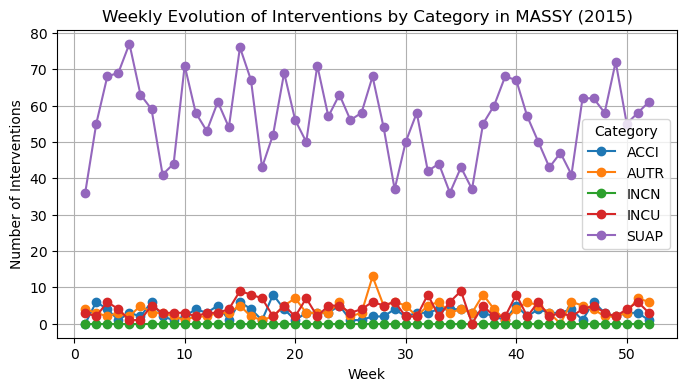

In [8]:
# Display data for MASSY in 2015
massy_data = interventions_features[
    (interventions_features["ope_nom_commune"] == "MASSY")
    & (interventions_features["ope_annee"] == 2015)
]

# Group by week and category
weekly_interventions = (
    massy_data.groupby(["ope_semaine", "ope_categorie"])["nb_ope"]
    .sum()
    .unstack()
)

# Plot the annual pattern
weekly_interventions.plot(kind="line", figsize=(8, 4), marker="o")

plt.title("Weekly Evolution of Interventions by Category in MASSY (2015)")
plt.xlabel("Week")
plt.ylabel("Number of Interventions")
plt.legend(title="Category")
plt.grid(True)
plt.show()

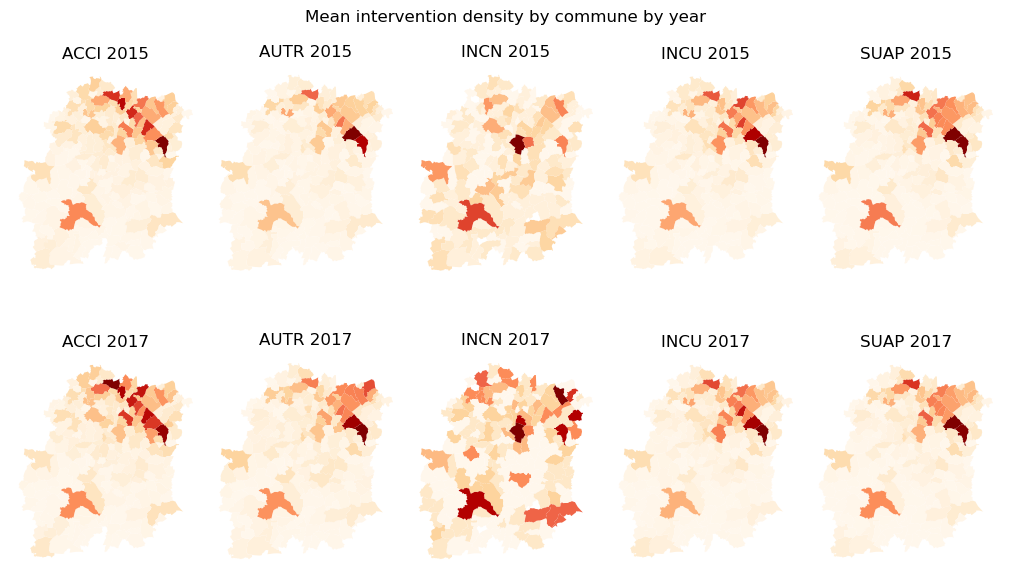

In [43]:
communes_91 = gpd.read_file(
    Path("extra_folders/communes_91_shp/communes-shapefile-dept-91.shp")
)
years=[2015, 2017]
fig, axes = plt.subplots(len(years), 5, figsize=(10, 6), layout="constrained")
plt.suptitle("Mean intervention density by commune by year")
for axs, year in zip(axes, years):
    mean_interventions = (
        interventions_features[interventions_features['ope_annee'] == year
                               ].groupby(["ope_code_insee", "ope_categorie"])[
            "nb_ope"
        ].mean().unstack()
    )
    map_inter = gpd.GeoDataFrame(
        pd.merge(communes_91, mean_interventions, 
                left_on="insee", right_on='ope_code_insee'))

    for ope_categorie, ax in zip(map_inter.columns[-5:], axs):
        map_inter.plot(ax=ax, column=ope_categorie, cmap='OrRd')
        ax.axis("off")
        ax.set_title(f"{ope_categorie} {year}")
    
plt.show()

**Insights on `interventions`**:

1. **General Trends and Disparities:**  
   - `SUAP` (Emergency assistance) is the most frequent category across all communes, highlighting its critical role.  
   - Significant variability is observed in other categories, indicating different risk profiles and needs across communes.

2. **Geographical and Temporal Insights:**  
   - Intervention volumes vary greatly between communes, influenced by geographical and socioeconomic factors.  
   - Weekly fluctuations suggest seasonal patterns and event-driven spikes, particularly for `SUAP`.

<div class="alert alert-block alert-success">
<b>Implications Implications for Predictive Modeling:</b><br>
   Demographic and geographical disparities, combined with temporal patterns, are key predictors for modeling interventions by municipality and category.
</div>

______

### 1.3. Exploration of yearly `communes_features`

This dataset contains annual variability factors for 126 municipalities in the Essonne department (over 196) from 2010 to 2018, as part of the “Prévisecours” mission. It includes demographic, educational, household, and economic indicators.

<div style="text-align: center;">
<img src="img/Communes_Essonne_Densites.png" width=450px alt="density"></img>
</div>

<div class="alert alert-block alert-warning">
This document contains information for only <b>126</b> municipalities over 196. 
You should handle missing data or use domain adaptation tools.
</div>

**Data dictionnary**
Variables information are avariable on [Data.gouv](https://www.data.gouv.fr/fr/datasets/description-des-communes-de-lessonne-meteo-pollution-maladies-tranches-dages/) (Fichiers>Description)

- `annee`: year of the statistic
- `region`: region code
- `dept`: department code
- `code_insee`: municipality code / department code followed by the municipality number (authority)
- `commune_nom`: municipality name (informative)
- `code_postal`: postal code of the municipality (informative)
- `tx_pop_15-24`: proportion of the population in the 15-24 age group
- `tx_pop_25-54`: proportion of the population in the 25-54 age group
- `tx_pop_55-79`: proportion of the population in the 55-79 age group
- `tx_pop_80+`: proportion of the population over 80 years old
- `tx_pop_solo_15-24`: proportion of the population in the 15-24 age group living alone
- `tx_pop_solo_25-54`: proportion of the population in the 25-54 age group living alone
- `tx_pop_solo_55-79`: proportion of the population in the 55-79 age group living alone
- `tx_pop_solo_80+`: proportion of the population over 80 years old living alone
- `tx_scol_2-5`: schooling rate of people aged 2 to 5 years
- `tx_scol_6-10`: schooling rate of people aged 6 to 10 years
- `tx_scol_11-14`: schooling rate of people aged 11 to 14 years
- `tx_scol_15-17`: schooling rate of people aged 15 to 17 years
- `tx_scol_18-24`: schooling rate of people aged 18 to 24 years
- `tx_scol_25-29`: schooling rate of people aged 25 to 29 years
- `tx_scol_30+`: schooling rate of people aged 30 years or older
- `ens_no_diplome`: rate of people aged 15 and over not in school with no diploma
- `ens_brevet`: rate of people aged 15 and over not in school with at most a BEPC, brevet des collèges, or DNB
- `ens_bac`: rate of people aged 15 and over not in school with a baccalaureate (general, technological, professional)
- `ens_sup`: rate of people aged 15 and over not in school with a higher education diploma
- `femmes_no_diplome`: rate of women aged 15 and over not in school with no diploma
- `femmes_brevet`: rate of women aged 15 and over not in school with at most a BEPC, brevet des collèges, or DNB
- `femmes_bac`: rate of women aged 15 and over not in school with a baccalaureate (general, technological, professional)
- `femmes_sup`: rate of women aged 15 and over not in school with a higher education diploma
- `hommes_no_diplome`: rate of men aged 15 and over not in school with no diploma
- `hommes_brevet`: rate of men aged 15 and over not in school with at most a BEPC, brevet des collèges, or DNB
- `hommes_bac`: rate of men aged 15 and over not in school with a baccalaureate (general, technological, professional)
- `hommes_sup`: rate of men aged 15 and over not in school with a higher education diploma
- `ens_post_bac`: rate of people aged 15 and over not in school with at least a baccalaureate (general, technological, professional)
- `hommes_pre_bac`: rate of men aged 15 and over not in school with no diploma, a BEPC, brevet des collèges, or DNB, at most a baccalaureate (general, technological, professional)
- `hommes_post_bac`: rate of men aged 15 and over not in school with at least a baccalaureate (general, technological, professional)
- `femmes_pre_bac`: rate of women aged 15 and over not in school with no diploma, a BEPC, brevet des collèges, or DNB, at most a baccalaureate (general, technological, professional)
- `femmes_post_bac`: rate of women aged 15 and over not in school with at least a baccalaureate (general, technological, professional)
- `tx_famille_avec_enf`: proportion of families with children
- `tx_famille_monoparent`: proportion of single-parent families
- `tx_famille_sans_enf`: proportion of families without children
- `tx_famille_jeune_sans_enf`: proportion of families with 0 children under 25 years old
- `tx_famille_jeune_1_enf`: proportion of families with 1 child under 25 years old
- `tx_famille_jeune_2_enf`: proportion of families with 2 children under 25 years old
- `tx_famille_jeune_3_enf`: proportion of families with 3 children under 25 years old
- `_tx_famille_jeune_4+enf`: proportion of families with 4+ children under 25 years old
- `tx_menage_ref_agric`: proportion of households whose reference person is a Farmer
- `tx_menage_ref_ceo`: proportion of households whose reference person is an Artisan, Merchant, Business Owner
- `tx_menage_ref_cadre`: proportion of households whose reference person is an Executive or exercises a higher intellectual profession
- `tx_menage_ref_interm`: proportion of households whose reference person is an Intermediate profession
- `tx_menage_ref_employe`: proportion of households whose reference person is an Employee
- `tx_menage_ref_ouvrier`: proportion of households whose reference person is a Worker
- `tx_menage_ref_retraite`: proportion of households whose reference person is Retired
- `tx_menage_ref_autre`: proportion of households whose reference person is Other without professional activity
- `pop_menage_ref_agric`: number of people in households whose reference person is a Farmer
- `pop_menage_ref_ceo`: number of people in households whose reference person is an Artisan, Merchant, Business Owner
- `pop_menage_ref_cadre`: number of people in households whose reference person is an Executive or exercises a higher intellectual profession
- `pop_menage_ref_interm`: number of people in households whose reference person is an Intermediate profession
- `pop_menage_ref_employe`: number of people in households whose reference person is an Employee
- `pop_menage_ref_ouvrier`: number of people in households whose reference person is a Worker
- `pop_menage_ref_retraite`: number of people in households whose reference person is Retired
- `pop_menage_ref_autre`: number of people in households whose reference person is Other without professional activity
- `tx_famille_jeune_avec_enf`: proportion of families with 1+ children under 25 years old
- `nb_etab_retraite`: number of retirement establishments in the municipality
- `nb_handi_mas`: number of establishments managing disabled people in the municipality
- `nb_enfance_aide`: number of child aid establishments in the municipality
- `nb_soins`: number of public care establishments in the municipality
- `nb_pharmacie`: number of pharmacies in the municipality
- `nb_psy`: number of psychiatric establishments in the municipality
- `nb_foyers`: number of shelters in the municipality
- `nb_mineurs_trouble`: number of establishments for minors in trouble in the municipality
- `nb_hopital_prive`: number of private care establishments in the municipality
- `idh2_sante_plaf`: idh2 health indicator
- `idh2_educ_plaf`: idh2 education indicator
- `idh2_revenu_plaf`: idh2 income indicator
- `idh2_indicateur`: idh2 regional human development indicator
- `idh2_pop`: reference population
- `nb_gares`: number of stations in the municipality
- `nb_trafic`: cumulative traffic in counts for the stations in the municipality
- `terminus`: indicator if the municipality has line terminuses
- `terminus_nb`: number of line terminuses in the municipality
- `trafic_0.5+`: during calculation periods (JOB, Saturday, Sunday), cumulative periods where stations in the municipality had more traffic than the department median
- `trafic_0.75+`: during calculation periods (JOB, Saturday, Sunday), cumulative periods where stations in the municipality had more traffic than the 0.75 percentile of the department
- `trafic_1.0`: during calculation periods (JOB, Saturday, Sunday), cumulative periods where stations in the municipality were among the top stations in the department in terms of traffic counts
- `caf_nb_pers_couv_rsa_prop`: rate of people covered by RSA in the municipality
- `caf_nb_allocataire_rsa_prop`: rate of RSA beneficiary households in the municipality
- `caf_nb_allocataires_prop`: rate of family branch beneficiary households in the municipality
- `caf_all_bas_revenu_prop`: rate of low-income beneficiary households in the municipality
- `caf_pers_bas_revenu_prop`: rate of low-income beneficiary people in the municipality
- `caf_nb_alloc_dep_100_prop`: rate of beneficiary households whose resources are 100% from CAF benefits in the municipality
- `caf_nb_alloc_dep_50_prop`: rate of beneficiary households whose resources are 50% or more from CAF benefits


In [10]:
# Display some basic information
communes_features = pd.read_csv("data/91-communes-features.csv")

print("\n### communes_features shape")
print(communes_features.shape)

print("\n### communes_features: Number of unique municipalities")
print(communes_features["code_insee"].nunique())

print("\n### communes_features: First 5 Rows")
display(communes_features.head())

print("\n### communes_features: Missing Values")
missing_values = communes_features.isnull().sum()
display(missing_values[missing_values > 0])

print("\n### communes_features: Basic Statistics")
display(communes_features.describe())

print("\n### communes_features: Data Types")
display(communes_features.dtypes)


### communes_features shape
(1143, 135)

### communes_features: Number of unique municipalities
126

### communes_features: First 5 Rows


,annee,region,dept,code_insee,commune_nom,code_postal,tx_pop_15-24,tx_pop_25-54,tx_pop_55-79,tx_pop_80+,...,caf_nb_allocataires_prop,caf_nb_alloc_dep_50_prop,caf_nb_alloc_dep_100_prop,pop_tx_natalite,pop_tx_mortalite,pop_tx_accroissement,pop_median_up,superficie,densite,commune_categ
0,2010,11,91,91016,ANGERVILLE,91670,0.14354,0.53400,0.27481,0.04766,...,0.0,0.011990,0.021316,0.01839,0.00586,0.01252,1,25.79,145.521520,2
1,2010,11,91,91017,ANGERVILLIERS,91470,0.15738,0.56819,0.19362,0.08080,...,0.0,0.000000,0.005471,0.01702,0.00608,0.01094,0,9.11,180.570801,0
2,2010,11,91,91021,ARPAJON,91290,0.15394,0.53404,0.25294,0.05909,...,0.0,0.019387,0.024210,0.01693,0.00908,0.00785,1,2.38,4442.857143,2
3,2010,11,91,91027,ATHIS MONS,91200,0.16379,0.53436,0.25933,0.04251,...,0.0,0.019840,0.027967,0.01701,0.00500,0.01201,1,8.61,3529.965157,2
4,2010,11,91,91038,AUVERS ST GEORGES,91580,0.14767,0.52769,0.28773,0.03692,...,0.0,0.004153,0.011628,0.01246,0.00664,0.00581,0,12.74,94.505495,0



### communes_features: Missing Values


tx_gares           783
tx_trafic          783
tx_terminus        783
tx_trafic_0.5+     783
tx_trafic_0.75+    783
tx_trafic_1.0      783
superficie           9
densite              9
dtype: int64


### communes_features: Basic Statistics


,annee,region,dept,code_insee,code_postal,tx_pop_15-24,tx_pop_25-54,tx_pop_55-79,tx_pop_80+,tx_pop_solo_15-24,...,caf_nb_allocataires_prop,caf_nb_alloc_dep_50_prop,caf_nb_alloc_dep_100_prop,pop_tx_natalite,pop_tx_mortalite,pop_tx_accroissement,pop_median_up,superficie,densite,commune_categ
count,1143.000000,1143.0,1143.0,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,...,1143.0,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1134.000000,1134.000000,1143.000000
mean,2014.000000,11.0,91.0,91363.661417,91485.826772,0.156549,0.516156,0.279196,0.048099,0.044509,...,0.0,0.009865,0.015761,0.012164,0.006274,0.006236,0.771654,9.679048,1399.454437,2.031496
std,2.583119,0.0,0.0,201.984359,343.279478,0.022107,0.041657,0.042870,0.019822,0.026806,...,0.0,0.007159,0.009096,0.004157,0.002827,0.005475,0.419951,6.837179,1572.747785,0.947328
min,2010.000000,11.0,91.0,91016.000000,91000.000000,0.086400,0.410570,0.090020,0.006170,0.000000,...,0.0,0.000000,0.000000,0.001220,0.000000,-0.014490,0.000000,1.780000,39.082442,0.000000
25%,2012.000000,11.0,91.0,91191.000000,91270.000000,0.145580,0.485840,0.254920,0.033000,0.028155,...,0.0,0.005169,0.009391,0.009425,0.004360,0.002915,1.000000,4.980000,195.492958,2.000000
50%,2014.000000,11.0,91.0,91347.000000,91470.000000,0.153200,0.513640,0.280200,0.046670,0.037620,...,0.0,0.008367,0.013573,0.011590,0.005770,0.006090,1.000000,8.265000,671.984436,2.000000
75%,2016.000000,11.0,91.0,91549.000000,91640.000000,0.164530,0.543980,0.303010,0.060350,0.054550,...,0.0,0.013146,0.020492,0.014670,0.007485,0.009845,1.000000,11.590000,2119.462514,3.000000
max,2018.000000,11.0,91.0,91692.000000,94390.000000,0.277840,0.676080,0.430150,0.123420,0.169160,...,0.0,0.039980,0.053614,0.033020,0.020930,0.033020,1.000000,46.010000,7338.565022,3.000000



### communes_features: Data Types


annee                     int64
region                    int64
dept                      int64
code_insee                int64
commune_nom              object
                         ...   
pop_tx_accroissement    float64
pop_median_up             int64
superficie              float64
densite                 float64
commune_categ             int64
Length: 135, dtype: object


### communes_features: disparities in population
   Most Populated Commune: EVRY - Population: 53699 habs
   Least Populated Commune: FONTAINE LA RIVIERE - Population: 245 habs
     Median Population: 5280
     Mean Population: 9709


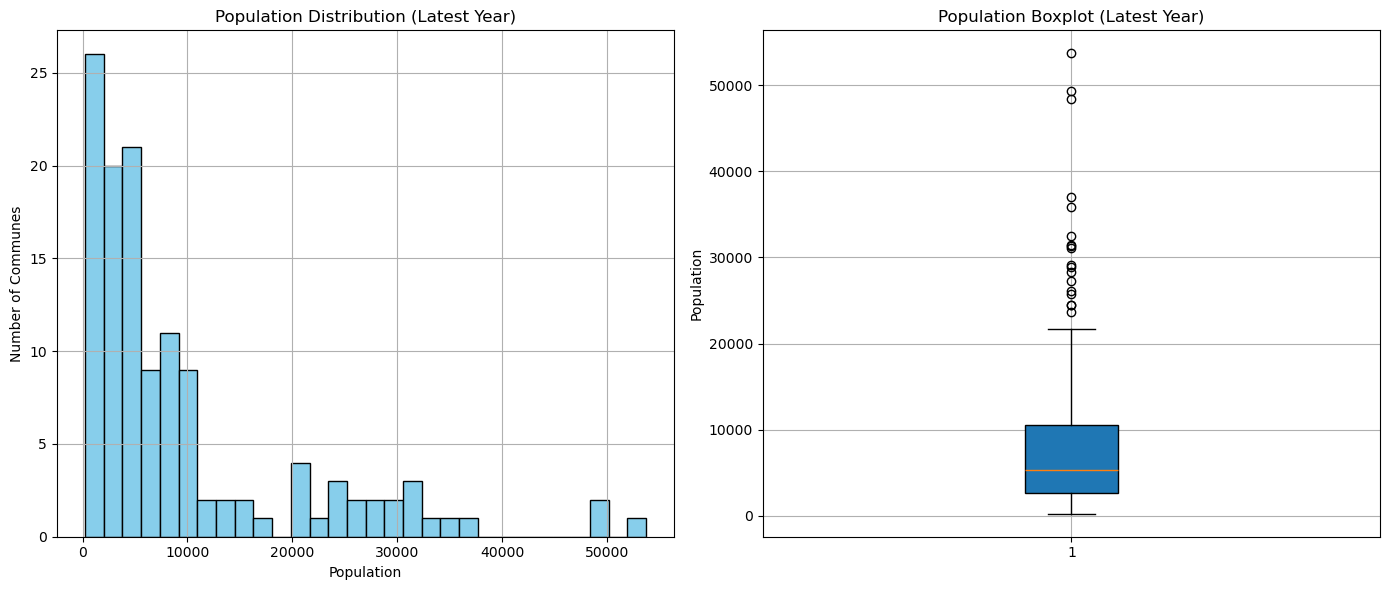

In [54]:
latest_population = communes_features.loc[
    communes_features.groupby("commune_nom")["annee"].idxmax()
]

print("\n### communes_features: disparities in population")
max_pop = latest_population.loc[latest_population["pop_pop"].idxmax()]
print(
    f"   Most Populated Commune: {max_pop['commune_nom']} - Population: {int(max_pop['pop_pop'])} habs"
)
min_pop = latest_population.loc[latest_population["pop_pop"].idxmin()]
print(
    f"   Least Populated Commune: {min_pop['commune_nom']} - Population: {int(min_pop['pop_pop'])} habs"
)
median_pop = latest_population["pop_pop"].median()
mean_pop = latest_population["pop_pop"].mean()
print(f"     Median Population: {int(median_pop)}")
print(f"     Mean Population: {int(mean_pop)}")

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].hist(
    latest_population["pop_pop"], bins=30, color="skyblue", edgecolor="black"
)
axs[0].set_title("Population Distribution (Latest Year)")
axs[0].set_xlabel("Population")
axs[0].set_ylabel("Number of Communes")
axs[0].grid(True)

axs[1].boxplot(latest_population["pop_pop"], vert=True, patch_artist=True)
axs[1].set_title("Population Boxplot (Latest Year)")
axs[1].set_ylabel("Population")
axs[1].grid(True)

plt.tight_layout()
plt.show()

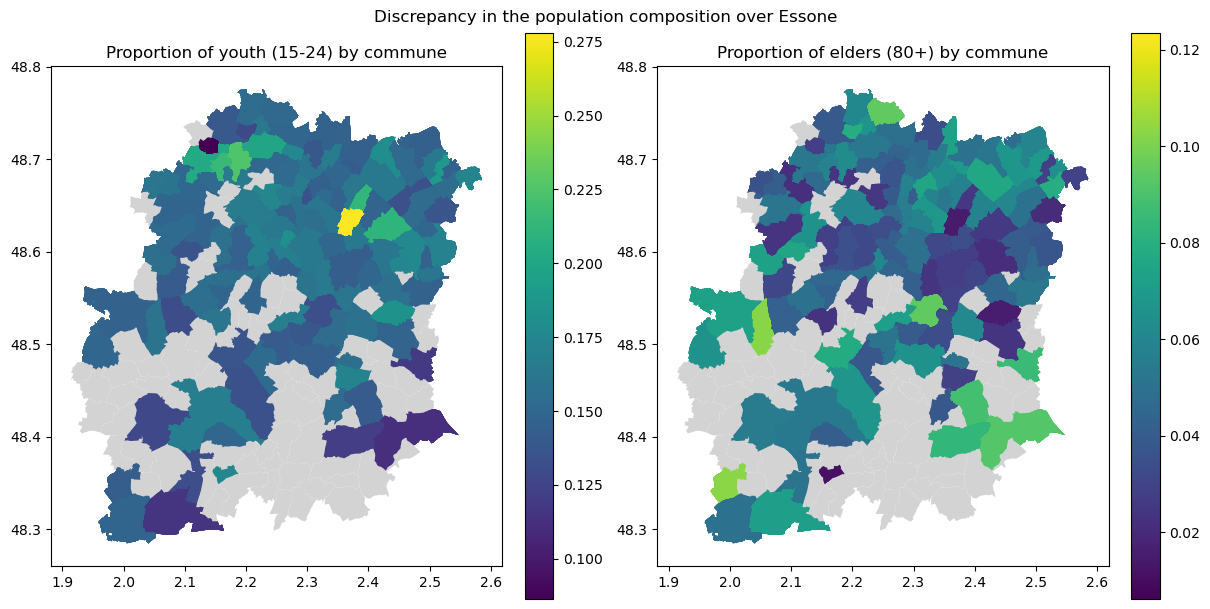

In [28]:
# Load the geographic features for display on a map
pop_density = gpd.GeoDataFrame(pd.merge(
    communes_91, 
    communes_features[["code_insee", "pop_pop", "tx_pop_15-24", "tx_pop_80+"]], 
    how='left', 
    left_on="insee", 
    right_on="code_insee"))

# Plot the population composition
fig, axs = plt.subplots(1, 2, figsize=(12, 6), layout='constrained')
# Proportion of youth
pop_density.plot(column="tx_pop_15-24", 
                 missing_kwds={
                     'color': 'lightgrey', 
                     "label": "Missing values"
                 },
                 ax=axs[0],
                 legend=True)
axs[0].set_title("Proportion of youth (15-24) by commune")

# Proportion of elders
pop_density.plot(column="tx_pop_80+", 
                 missing_kwds={
                     'color': 'lightgrey', 
                     "label": "Missing values"
                 },
                 ax=axs[1],
                 legend=True)
axs[1].set_title("Proportion of elders (80+) by commune")
plt.suptitle("Discrepancy in the population composition over Essone")
plt.show()


### communes_features: disparities in population density


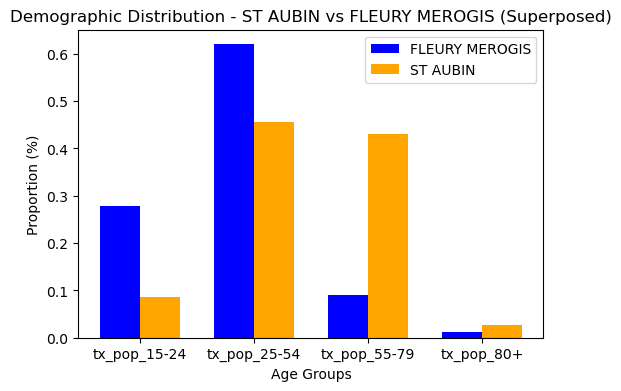

In [55]:
print("\n### communes_features: disparities in population density")
demographic_cols = [
    "tx_pop_15-24",
    "tx_pop_25-54",
    "tx_pop_55-79",
    "tx_pop_80+",
]
selected_cities = communes_features[
    communes_features["commune_nom"].isin(["ST AUBIN", "FLEURY MEROGIS"])
]
communes = selected_cities["commune_nom"].values
values = selected_cities[demographic_cols].values
bar_width = 0.35
index = np.arange(len(demographic_cols))

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(index, values[0], bar_width, label=communes[0], color="blue")
ax.bar(
    index + bar_width, values[1], bar_width, label=communes[1], color="orange"
)
ax.set_xlabel("Age Groups")
ax.set_ylabel("Proportion (%)")
ax.set_title(
    "Demographic Distribution - ST AUBIN vs FLEURY MEROGIS (Superposed)"
)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(demographic_cols)
ax.legend()
plt.show()

**Insights on `communes_features`**

1. **Missing Data:**  
   - Transport-related variables show 783 missing values, likely due to the absence of train stations in some municipalities.  
   - This may impact interventions related to transport accidents or population flows.

2. **Population Distribution:**  
   - Significant population variation between communes (from **203** in FONTAINE LA RIVIERE to **53,871** in EVRY).  
   - Population density likely influences the frequency and type of interventions.

3. **Demographic Disparities:**  
   - Notable differences in age distribution between communes, potentially impacting the types of interventions needed.

<div class="alert alert-block alert-success">
<b>Implications for the Challenge</b>:<br>  
   Demographics, population density, and transport infrastructure are key predictors for modeling interventions by municipality and type.
</div>

---

### 1.4. Exploration of weekly `variability_features`

This dataset contains **weekly variability factors** for municipalities in the Essonne department from **2010 to 2018**, including calendar events, pollution, weather, and health indicators, as part of the “Prévisecours” mission.

<div style="display: flex; justify-content: center; align-items: center; gap: 50px;">
<img src="img/meteo.png"width=458px alt="meteo"></img>
<img src="img/grippe.jpg" width=400px alt="grippe"></img>
</div>

##### Data.gouv Description

A set of weekly varying factors for municipalities in the Essonne department, from 2010 to 2018.  
Work conducted as part of the “Prévisecours” mission.

**Data dictionnary**
Variables information is available on [Data.gouv](https://www.data.gouv.fr/fr/datasets/description-des-communes-de-lessonne-meteo-pollution-maladies-tranches-dages/) (Fichiers>Description)

- `cal_date`: date of the day
- `cal_annee`: year of the day
- `cal_jour_semaine`: day of the week
- `cal_semaine`: week of the year
- `cal_semaine_ramadan`: indicator of Ramadan week (0: no, 1: yes)
- `cal_semaine_vacances`: indicator of vacation week (0: no, 1: yes)
- `cal_semaine_jour_ferie`: indicator of week with at least one public holiday (0: no, 1: yes)
- `cal_is_summer`: indicator of July or August week
- `cal_semaine_soldes`: indicator of week with at least one sale day
- `pollution_commune`: name of the municipality (informative)
- `pollution_code_postal`: postal code of the municipality (informative)
- `pollution_code_insee`: INSEE code of the municipality (**authority**)
- `pollution_cumul_PM10`: cumulative PM10 alert levels over the week
- `pollution_cumul_NO2`: cumulative NO2 alert levels over the week
- `pollution_cumul_O3`: cumulative O3 alert levels over the week
- `pollen_cumul_graminee`: cumulative grass pollen levels over the week
- `pollen_cumul_taxons`: cumulative taxon levels (generalization) over the week
- `meteo_avg_humidity`: average humidity rate over the week
- `meteo_avg_moon`: average moon phase over the week
- `meteo_avg_precip`: average precipitation rate over the week
- `meteo_avg_pression`: average pressure rate over the week
- `meteo_avg_temp_min`: average minimum daily temperature over the week
- `meteo_avg_temp_max`: average maximum daily temperature over the week
- `meteo_avg_wind_speed`: average wind speed over the week
- `meteo_avg_day_duration`: average day duration over the week
- `diharee_nbr`: number of diarrhea cases over the week
- `diharee_nbr_pour_100k_hab`: number of diarrhea cases per 100k inhabitants over the week
- `tx_diarrhee_par_hab`: diarrhea rate per inhabitant over the week
- `grippe_nbr`: number of flu cases over the week
- `grippe_nbr_pour_100k_hab`: number of flu cases per 100k inhabitants over the week
- `tx_grippe_par_hab`: flu rate per inhabitant over the week
- `varicelle_nbr`: number of chickenpox cases over the week
- `varicelle_nbr_pour_100k_hab`: number of chickenpox cases per 100k inhabitants over the week
- `tx_varicelle_par_hab`: chickenpox rate per inhabitant over the week

In [44]:
variability_features = pd.read_csv("data/91-variability-features.csv")

print("\n### variability_features: First 5 Rows")
display(variability_features.head())

print("\n### variability_features: Missing Values")
missing_values = variability_features.isnull().sum()
display(missing_values[missing_values > 0])

print("\n### variability_features: Number of unique municipalities")
print(variability_features["pollution_code_insee"].nunique())

print("\n### variability_features: Data Types and Basic Statistics")
display(variability_features.info())
display(variability_features.describe(include="all"))



### variability_features: First 5 Rows


,cal_annee,cal_semaine,cal_semaine_jour_ferie,cal_semaine_ramadan,cal_semaine_soldes,cal_semaine_summer,cal_semaine_vacances,diharee_nbr,diharee_nbr_pour_100k_hab,grippe_nbr,...,prev_avg_precip,prev_avg_pression,prev_avg_temp_max,prev_avg_temp_min,prev_avg_wind_speed,tx_diarrhee_par_hab,tx_grippe_par_hab,tx_varicelle_par_hab,varicelle_nbr,varicelle_nbr_pour_100k_hab
0,2010,1,0,0,0,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010,2,0,0,0,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010,3,0,0,0,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010,4,0,0,0,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010,5,0,0,0,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



### variability_features: Missing Values


diharee_nbr                      405
diharee_nbr_pour_100k_hab        405
grippe_nbr                       405
grippe_nbr_pour_100k_hab         405
meteo_avg_day_duration           157
meteo_avg_humidity               157
meteo_avg_moon                   157
meteo_avg_precip                 157
meteo_avg_pression               157
meteo_avg_temp_max               157
meteo_avg_temp_min               157
meteo_avg_wind_speed             157
pollen_cumul_graminee          41103
pollen_cumul_taxons            41103
pollution_code_insee             209
pollution_code_postal            209
pollution_commune                209
pollution_cumul_NO2              209
pollution_cumul_O3               209
pollution_cumul_PM10             209
prev_avg_day_duration            209
prev_avg_humidity                209
prev_avg_moon                    209
prev_avg_precip                  209
prev_avg_pression                209
prev_avg_temp_max                209
prev_avg_temp_min                209
p


### variability_features: Number of unique municipalities
196

### variability_features: Data Types and Basic Statistics
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51295 entries, 0 to 51294
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cal_annee                    51295 non-null  int64  
 1   cal_semaine                  51295 non-null  int64  
 2   cal_semaine_jour_ferie       51295 non-null  int64  
 3   cal_semaine_ramadan          51295 non-null  int64  
 4   cal_semaine_soldes           51295 non-null  int64  
 5   cal_semaine_summer           51295 non-null  int64  
 6   cal_semaine_vacances         51295 non-null  int64  
 7   diharee_nbr                  50890 non-null  float64
 8   diharee_nbr_pour_100k_hab    50890 non-null  float64
 9   grippe_nbr                   50890 non-null  float64
 10  grippe_nbr_pour_100k_hab     50890 non-null  float64
 11  meteo_avg_

None

,cal_annee,cal_semaine,cal_semaine_jour_ferie,cal_semaine_ramadan,cal_semaine_soldes,cal_semaine_summer,cal_semaine_vacances,diharee_nbr,diharee_nbr_pour_100k_hab,grippe_nbr,...,prev_avg_precip,prev_avg_pression,prev_avg_temp_max,prev_avg_temp_min,prev_avg_wind_speed,tx_diarrhee_par_hab,tx_grippe_par_hab,tx_varicelle_par_hab,varicelle_nbr,varicelle_nbr_pour_100k_hab
count,51295.000000,51295.000000,51295.000000,51295.000000,51295.000000,51295.000000,51295.000000,50890.000000,50890.000000,50890.000000,...,51086.000000,51086.000000,51086.000000,51086.000000,51086.000000,50890.000000,50890.000000,50890.000000,50890.000000,50890.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2015.967443,26.739331,0.419846,0.095233,0.257920,0.186626,0.443786,14472.312380,120.052957,9280.057221,...,0.031898,1016.990411,16.703805,8.683361,1.808978,0.001201,0.000769,0.000199,2401.331774,19.916094
std,1.434183,15.137442,0.785392,0.293540,0.437494,0.389615,0.496835,6967.626267,58.042746,16236.884961,...,0.036783,6.432574,7.112275,5.195113,0.595439,0.000580,0.001346,0.000162,1952.671931,16.210422
min,2010.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3053.000000,25.000000,0.000000,...,0.000000,996.619000,2.151000,-4.113000,0.699000,0.000250,0.000000,0.000000,0.000000,0.000000
25%,2015.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8749.000000,72.000000,565.000000,...,0.005000,1013.970000,10.737000,4.476000,1.370000,0.000720,0.000050,0.000070,822.000000,7.000000
50%,2016.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13314.000000,110.000000,2409.000000,...,0.019000,1016.807000,16.791000,8.300000,1.726000,0.001100,0.000200,0.000160,1913.000000,16.000000
75%,2017.000000,40.000000,1.000000,0.000000,1.000000,0.000000,1.000000,19117.000000,158.000000,9566.000000,...,0.041000,1020.480000,23.039000,13.219000,2.186000,0.001580,0.000790,0.000270,3304.000000,27.000000


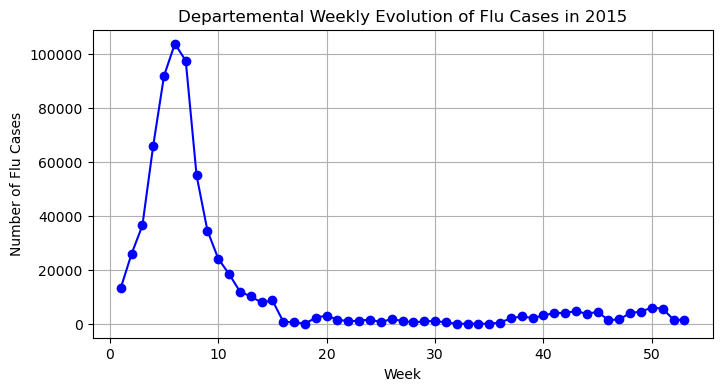

In [46]:
# Display the variability of the flu
grippe_2015 = variability_features[(variability_features["cal_annee"] == 2015)]
grippe_2015_weekly = grippe_2015.groupby("cal_semaine").first().reset_index()

plt.figure(figsize=(8, 4))
plt.plot(
    grippe_2015_weekly["cal_semaine"],
    grippe_2015_weekly["grippe_nbr"],
    marker="o",
    linestyle="-",
    color="blue",
)
plt.title("Departemental Weekly Evolution of Flu Cases in 2015")
plt.xlabel("Week")
plt.ylabel("Number of Flu Cases")
plt.grid(True)
plt.show()

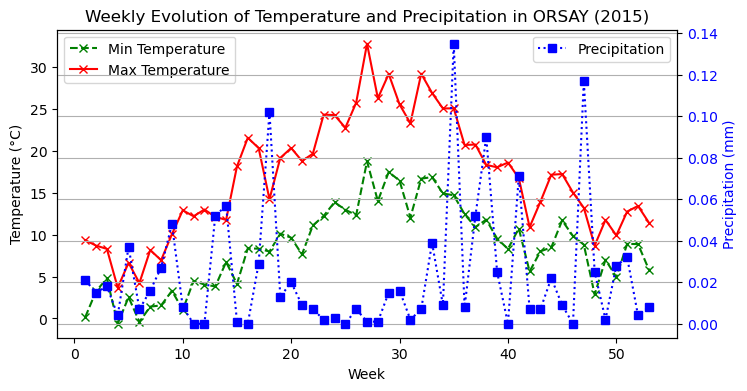

In [ ]:
# Display the variability of the weather
orsay_data = variability_features[
    (variability_features["pollution_commune"] == "ORSAY")
    & (variability_features["cal_annee"] == 2015)
]
orsay_data_weekly = orsay_data.groupby("cal_semaine").first().reset_index()

fig, ax1 = plt.subplots(figsize=(8, 4))
ax1.plot(
    orsay_data_weekly["cal_semaine"],
    orsay_data_weekly["meteo_avg_temp_min"],
    marker="x",
    linestyle="--",
    color="green",
    label="Min Temperature",
)
ax1.plot(
    orsay_data_weekly["cal_semaine"],
    orsay_data_weekly["meteo_avg_temp_max"],
    marker="x",
    linestyle="-",
    color="red",
    label="Max Temperature",
)
ax1.set_xlabel("Week")
ax1.set_ylabel("Temperature (°C)", color="black")
ax1.tick_params(axis="y", labelcolor="black")
ax1.set_title(
    "Weekly Evolution of Temperature and Precipitation in ORSAY (2015)"
)
ax2 = ax1.twinx()
ax2.plot(
    orsay_data_weekly["cal_semaine"],
    orsay_data_weekly["meteo_avg_precip"],
    marker="s",
    linestyle=":",
    color="blue",
    label="Precipitation",
)
ax2.set_ylabel("Precipitation (mm)", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.grid(True)
plt.show()

**Insights on weekly `variability_features`**

1. **Epidemiological Trends:**
   - **Flu Peaks**: Significant national spikes in early 2015, likely impacting emergency medical interventions.

2. **Weather Influence:**
   - Seasonal temperature variations and rainfall peaks may correlate with specific intervention types, such as accidents or weather-related emergencies.

<div class="alert alert-block alert-success">
<b>Implications for the Challenge</b>:<br> 

- Weather patterns and epidemiological trends are key predictors of intervention frequency and type.

- Including these variables could improve model accuracy for forecasting emergency services demand.
</div>

---

## 2. Pre-processing the data



In [59]:
import warnings

warnings.filterwarnings("ignore")
from download_data import process_data


print("\n### Checking if data files are present")
if (
    os.path.exists("data/public/train.h5")
    and os.path.exists("data/public/test.h5")
    and os.path.exists("data/test.h5")
):
    print("   Files already exist")
else:
    print("   Files are missing : runnning preprocess function")
    process_data()


### Checking if data files are present
   Files already exist


  
Let's first look at the merged datasets.

In [60]:
train_file = "data/public/train.h5"
test_file = "data/public/test.h5"

X_train = pd.read_hdf(train_file, key="data")
y_train = pd.read_hdf(train_file, key="target")
X_test = pd.read_hdf(test_file, key="data")
y_test = pd.read_hdf(test_file, key="target")

In [61]:
display(X_train.head())
display(y_train.head())
display(X_test.head())
display(y_test.head())
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

,cal_annee,cal_semaine,cal_semaine_jour_ferie,cal_semaine_ramadan,cal_semaine_soldes,cal_semaine_summer,cal_semaine_vacances,diharee_nbr,diharee_nbr_pour_100k_hab,grippe_nbr,grippe_nbr_pour_100k_hab,meteo_avg_day_duration,meteo_avg_humidity,meteo_avg_moon,meteo_avg_precip,meteo_avg_pression,meteo_avg_temp_max,meteo_avg_temp_min,meteo_avg_wind_speed,pollen_cumul_graminee,pollen_cumul_taxons,pollution_code_insee,pollution_code_postal,pollution_commune,pollution_cumul_NO2,pollution_cumul_O3,pollution_cumul_PM10,prev_avg_day_duration,prev_avg_humidity,prev_avg_moon,prev_avg_precip,prev_avg_pression,prev_avg_temp_max,prev_avg_temp_min,prev_avg_wind_speed,tx_diarrhee_par_hab,tx_grippe_par_hab,tx_varicelle_par_hab,varicelle_nbr,varicelle_nbr_pour_100k_hab,...,trafic_1.0,tx_gares,tx_trafic,tx_terminus,tx_trafic_0.5+,tx_trafic_0.75+,tx_trafic_1.0,caf_tx_pers_couv_rsa,caf_tx_pers_par_foyer_alloc,caf_tx_rsa_socle_majore_pers_couv,caf_tx_rsa_socle_non_majore_pers_couv,caf_tx_allocataire_rsa,caf_tx_allocataires,caf_tx_dont_rsa_jeune,caf_tx_rsa_socle_majore,caf_tx_rsa_socle_non_majore,caf_tx_all_bas_revenu,caf_tx_allocataires_ress,caf_tx_pers_couv_ress,caf_tx_bas_revenu,caf_tx_alloc_dep_100,caf_tx_alloc_dep_50,pop_deces_nb,pop_naiss_nb,pop_pop,nb_trafic_prop,caf_pers_bas_revenu_prop,caf_all_bas_revenu_prop,caf_nb_pers_couv_rsa_prop,caf_nb_allocataire_rsa_prop,caf_nb_allocataires_prop,caf_nb_alloc_dep_50_prop,caf_nb_alloc_dep_100_prop,pop_tx_natalite,pop_tx_mortalite,pop_tx_accroissement,pop_median_up,superficie,densite,commune_categ
0,2010,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,nb_ope_ACCI,nb_ope_AUTR,nb_ope_INCN,nb_ope_INCU,nb_ope_SUAP
0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,7.0
2,2.0,1.0,0.0,0.0,0.0
3,1.0,1.0,0.0,1.0,19.0
4,0.0,0.0,0.0,0.0,0.0


,cal_annee,cal_semaine,cal_semaine_jour_ferie,cal_semaine_ramadan,cal_semaine_soldes,cal_semaine_summer,cal_semaine_vacances,diharee_nbr,diharee_nbr_pour_100k_hab,grippe_nbr,grippe_nbr_pour_100k_hab,meteo_avg_day_duration,meteo_avg_humidity,meteo_avg_moon,meteo_avg_precip,meteo_avg_pression,meteo_avg_temp_max,meteo_avg_temp_min,meteo_avg_wind_speed,pollen_cumul_graminee,pollen_cumul_taxons,pollution_code_insee,pollution_code_postal,pollution_commune,pollution_cumul_NO2,pollution_cumul_O3,pollution_cumul_PM10,prev_avg_day_duration,prev_avg_humidity,prev_avg_moon,prev_avg_precip,prev_avg_pression,prev_avg_temp_max,prev_avg_temp_min,prev_avg_wind_speed,tx_diarrhee_par_hab,tx_grippe_par_hab,tx_varicelle_par_hab,varicelle_nbr,varicelle_nbr_pour_100k_hab,...,trafic_1.0,tx_gares,tx_trafic,tx_terminus,tx_trafic_0.5+,tx_trafic_0.75+,tx_trafic_1.0,caf_tx_pers_couv_rsa,caf_tx_pers_par_foyer_alloc,caf_tx_rsa_socle_majore_pers_couv,caf_tx_rsa_socle_non_majore_pers_couv,caf_tx_allocataire_rsa,caf_tx_allocataires,caf_tx_dont_rsa_jeune,caf_tx_rsa_socle_majore,caf_tx_rsa_socle_non_majore,caf_tx_all_bas_revenu,caf_tx_allocataires_ress,caf_tx_pers_couv_ress,caf_tx_bas_revenu,caf_tx_alloc_dep_100,caf_tx_alloc_dep_50,pop_deces_nb,pop_naiss_nb,pop_pop,nb_trafic_prop,caf_pers_bas_revenu_prop,caf_all_bas_revenu_prop,caf_nb_pers_couv_rsa_prop,caf_nb_allocataire_rsa_prop,caf_nb_allocataires_prop,caf_nb_alloc_dep_50_prop,caf_nb_alloc_dep_100_prop,pop_tx_natalite,pop_tx_mortalite,pop_tx_accroissement,pop_median_up,superficie,densite,commune_categ
82124,2018,1,2,0,0,0,1,15117.0,124.0,25234.0,206.0,505.4,0.859,0.589,0.081,1007.531,10.737,6.709,3.206,NaN,NaN,91001.0,91150.0,ABBEVILLE LA RIVIERE,0.0,3.0,0.0,505.4,0.859,0.589,0.081,1007.531,10.737,6.709,3.206,0.00124,0.00206,0.00009,1077.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82125,2018,1,2,0,0,0,1,15117.0,124.0,25234.0,206.0,505.4,0.859,0.589,0.081,1007.531,10.737,6.709,3.206,NaN,NaN,91016.0,91670.0,ANGERVILLE,0.0,6.0,0.0,505.4,0.859,0.589,0.081,1007.531,10.737,6.709,3.206,0.00124,0.00206,0.00009,1077.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82126,2018,1,2,0,0,0,1,15117.0,124.0,25234.0,206.0,505.4,0.859,0.589,0.081,1007.531,10.737,6.709,3.206,NaN,NaN,91017.0,91470.0,ANGERVILLIERS,0.0,3.0,0.0,505.4,0.859,0.589,0.081,1007.531,10.737,6.709,3.206,0.00124,0.00206,0.00009,1077.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82127,2018,1,2,0,0,0,1,15117.0,124.0,25234.0,206.0,505.4,0.859,0.589,0.081,1007.531,10.737,6.709,3.206,NaN,NaN,91021.0,91290.0,ARPAJON,0.0,3.0,0.0,505.4,0.859,0.589,0.081,1007.531,10.737,6.709,3.206,0.00124,0.00206,0.00009,1077.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82128,2018,1,2,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,nb_ope_ACCI,nb_ope_AUTR,nb_ope_INCN,nb_ope_INCU,nb_ope_SUAP
82124,0.0,0.0,0.0,0.0,0.0
82125,0.0,1.0,0.0,0.0,9.0
82126,1.0,1.0,0.0,0.0,3.0
82127,0.0,7.0,0.0,1.0,22.0
82128,0.0,0.0,0.0,0.0,0.0


(82124, 172) (82124, 5) (588, 172) (588, 5)


In [62]:
print("\n### Checking for missing values in the data")
missing_values = X_train.isnull().sum()
display(missing_values[missing_values > 0])


### Checking for missing values in the data


diharee_nbr                  41160
diharee_nbr_pour_100k_hab    41160
grippe_nbr                   41160
grippe_nbr_pour_100k_hab     41160
meteo_avg_day_duration       40964
                             ...  
pop_tx_accroissement         82124
pop_median_up                82124
superficie                   82124
densite                      82124
commune_categ                82124
Length: 162, dtype: int64

## Challenge Evaluation

For this challenge, the performance of the model is evaluated using the **Weighted Mean Absolute Error (WMAE)**, defined as:

$$
WMAE = \sum_{c \in C} \left( \frac{K}{\mu_c + K} \times \frac{1}{n_c} \sum_{i=1}^{n_c} |y_{pred}^{i,c} - y_{true}^{i,c}| \right)
$$

Where:
- $ C $ is the set of intervention categories: `[SUAP, INCN, INCU, ACCI, AUTR]`
- $ n_c $ is the number of predictions for category $ c $
- $ y_{pred}^{i,c} $ is the predicted value for the $ i^{th} $ observation of category $ c $
- $ y_{true}^{i,c} $ is the true value for the $ i^{th} $ observation of category $ c $
- $ \mu_c $ is the **weekly mean number of interventions** for category $ c $ 
- $ K $ is the **mean of total weekly interventions**, used as both:
  - a **normalizing constant** in the denominator, to balance category influence
  - a **scaling factor** in the numerator, ensuring a meaningful score magnitude


### Weighting Strategy:
The weights are calculated using the formula:

$$
\text{Weight for category } c = \frac{K}{\mu_c + K}
$$

This approach:
- **Balances the influence** of each category by giving **lower weights** to frequent categories (e.g., SUAP) and **higher weights** to rare categories (e.g., INCN).
- **Normalizes the impact** using $ K $, which avoids extreme weighting disparities.
- **Scales the score** using the same $ K $, ensuring that the final WMAE remains interpretable and comparable across models.


### Why This Approach?  
- **Avoids Overfitting to Frequent Categories**: By normalizing with $ K $, the model is discouraged from focusing excessively on the most common categories.
- **Maintains Interpretability**: Using $ K $ as a multiplier ensures the WMAE is on a similar scale as traditional MAE, making it easier to compare with other metrics.
- **Reflects Operational Reality**: Weights are calculated using data from **2017**, chosen as the **representative year** for its demographic characteristics being closest to the target prediction year. This ensures the model is evaluated in a context consistent with the operational environment.


This metric encourages the model to **accurately predict all types of interventions** without being biased by the most common ones while ensuring the score remains interpretable and relevant to the operational context.

In [63]:
print("\n### Computing MAE weights")
# X = X_train.copy()
# X['annee'] = X['semaine'].astype(str).str[:4].astype(int)
y_2017 = y_train[X_train["cal_annee"] == 2017]
mean_by_category = y_2017.mean()

print("\n### Mean annual interventions for 2017 -> MUc: ")
print(mean_by_category.round(2))
sum_means = mean_by_category.sum()
y_2017["sum"] = y_2017.sum(axis=1)

print(
    f"\n### mean of total weekly interventions in 2017 -> K: {sum_means.round(2)}"
)
weights = sum_means / (mean_by_category + sum_means)

print("\n### Normalized Weights per Category for WMAE -> Wc:")
print(weights.round(2))


### Computing MAE weights

### Mean annual interventions for 2017 -> MUc: 
nb_ope_ACCI    0.48
nb_ope_AUTR    0.48
nb_ope_INCN    0.02
nb_ope_INCU    0.57
nb_ope_SUAP    7.23
dtype: float64

### mean of total weekly interventions in 2017 -> K: 8.79

### Normalized Weights per Category for WMAE -> Wc:
nb_ope_ACCI    0.95
nb_ope_AUTR    0.95
nb_ope_INCN    1.00
nb_ope_INCU    0.94
nb_ope_SUAP    0.55
dtype: float64


### A first simple model 

We can start by building a simple model using only the 10 first numerical features to see how well we can predict the number of interventions for each category.   
This approach allows us to establish a baseline performance before incorporating more complex preprocessing steps or categorical data.

In [64]:
from sklearn.pipeline import make_pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from problem import get_train_data, get_test_data, WMAE
set_config(transform_output="pandas")


def preprocess_data(X, n_columns=10):
    categorical_columns = X.select_dtypes(include=[object]).columns
    X_clean = X.drop(columns=categorical_columns)
    X_clean = X_clean.iloc[:, :n_columns]
    X_clean.fillna(0, inplace=True)
    return X_clean


class MultiOutputRegressorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, estimator):
        self.estimator = MultiOutputRegressor(estimator)

    def fit(self, X, y):
        self.estimator.fit(X, y)
        return self

    def transform(self, X):
        return self.estimator.predict(X)

    def predict(self, X):
        return self.estimator.predict(X)

def get_estimator():
    return make_pipeline(
        FunctionTransformer(preprocess_data),
        MultiOutputRegressorTransformer(
            RandomForestRegressor(n_estimators=50)
            ),
    )
# Create estimator
model = get_estimator()

X_df, y = get_train_data()
X_df_test, y_test = get_test_data()
model.fit(X_df, y)

y_train_pred = model.predict(X_df)
y_test_pred = model.predict(X_df_test)

# y_train_pred = pd.DataFrame(y_train_pred, columns=y.columns, index=X_df.index)
# y_test_pred = pd.DataFrame(
#     y_test_pred, columns=y.columns, index=X_df_test.index
# )

wmae_scorer = WMAE()
print(f"Score on train: \n         WMAE = {wmae_scorer(y, y_train_pred)}")
print(f"Score on test: \n         WMAE = {wmae_scorer(y_test, y_test_pred)}")

Load train data, X.shape=(82124, 172), y.shape=(82124, 5)
Load test data, X.shape=(588, 172), y.shape=(588, 5)
Score on train: 
         WMAE = 9.650382634389949
Score on test: 
         WMAE = 10.590155173573098


# Submission format

Here, you should describe the submission format. This is the format the participants should follow to submit their predictions on the RAMP plateform.

This section also show how to use the `ramp-workflow` library to test the submission locally.

## The pipeline workflow

The input data are stored in a dataframe. To go from a dataframe to a numpy array we will use a scikit-learn column transformer. The first example we will write will just consist in selecting a subset of columns we want to work with.

In [67]:
from sklearn.pipeline import make_pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from problem import get_train_data, get_test_data, WMAE
from sklearn.utils.validation import check_is_fitted

set_config(transform_output="pandas")


def preprocess_data(X, n_columns=10):
    categorical_columns = X.select_dtypes(include=[object]).columns
    X_clean = X.drop(columns=categorical_columns)
    X_clean = X_clean.iloc[:, :n_columns]
    X_clean.fillna(0, inplace=True)
    return X_clean


class MultiOutputRegressorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, estimator=None):
        self.estimator = estimator

    def fit(self, X, y):
        self.estimator_ = MultiOutputRegressor(self.estimator)
        self.estimator_.fit(X, y)
        return self

    def transform(self, X):
        check_is_fitted(self, 'estimator_')
        return self.estimator_.predict(X)

    def predict(self, X):
        check_is_fitted(self, 'estimator_')
        return self.estimator_.predict(X)

def get_estimator():
    return make_pipeline(
        FunctionTransformer(preprocess_data),
        MultiOutputRegressorTransformer(
            RandomForestRegressor(n_estimators=50)
            ),
    )
# Create estimator
model = get_estimator()

X_df, y = get_train_data()
model.fit(X_df, y)


Load train data, X.shape=(82124, 172), y.shape=(82124, 5)


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function preprocess_data at 0x16a8c99e0>)),
                ('multioutputregressortransformer',
                 MultiOutputRegressorTransformer(estimator=RandomForestRegressor(n_estimators=50)))])

## Testing using a scikit-learn pipeline

In [68]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from problem import WMAE, get_test_data
from sklearn.model_selection import cross_val_score

X_df, y = get_test_data()

# Make predictions
y_pred = model.predict(X_df)

# Calculate scores
mse = mean_squared_error(y, y_pred, multioutput='uniform_average')
mae = mean_absolute_error(y, y_pred, multioutput='uniform_average')
r2 = r2_score(y, y_pred, multioutput='uniform_average')

# Custom WMAE score
wmae_scorer = WMAE(name="weighted_mean_absolute_error", precision=5)
wmae_score = wmae_scorer(y, y_pred)

# Print scores
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R² Score: {r2}')
print(f'Weighted Mean Absolute Error: {wmae_score}')

Load test data, X.shape=(588, 172), y.shape=(588, 5)
Mean Squared Error: 41.9410540763798
Mean Absolute Error: 2.273799903905153
R² Score: -0.027655432463404538
Weighted Mean Absolute Error: 10.543555665635388


## Submission

To submit your code, you can refer to the [online documentation](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html).